Before we get started, a couple of reminders to keep in mind when using iPython notebooks:

- Remember that you can see from the left side of a code cell when it was last run if there is a number within the brackets.
- When you start a new notebook session, make sure you run all of the cells up to the point where you last left off. Even if the output is still visible from when you ran the cells in your previous session, the kernel starts in a fresh state so you'll need to reload the data, etc. on a new session.
- The previous point is useful to keep in mind if your answers do not match what is expected in the lesson's quizzes. Try reloading the data and run all of the processing steps one by one in order to make sure that you are working with the same variables and data that are at each quiz stage.


## Load Data from CSVs

In [1]:
import unicodecsv

def read_csv(filename):
    with open(filename, 'rb') as f:
        reader = unicodecsv.DictReader(f)
        return list(reader)
    
enrollments = read_csv('enrollments.csv')
daily_engagement = read_csv('daily_engagement.csv')
project_submissions = read_csv('project_submissions.csv')

## Fixing Data Types

In [2]:
from datetime import datetime as dt

# Takes a date as a string, and returns a Python datetime object. 
# If there is no date given, returns None
def parse_date(date):
    if date == '':
        return None
    else:
        return dt.strptime(date, '%Y-%m-%d')
    
# Takes a string which is either an empty string or represents an integer,
# and returns an int or None.
def parse_maybe_int(i):
    if i == '':
        return None
    else:
        return int(i)

# Clean up the data types in the enrollments table
for enrollment in enrollments:
    enrollment['cancel_date'] = parse_date(enrollment['cancel_date'])
    enrollment['days_to_cancel'] = parse_maybe_int(enrollment['days_to_cancel'])
    enrollment['is_canceled'] = enrollment['is_canceled'] == 'True'
    enrollment['is_udacity'] = enrollment['is_udacity'] == 'True'
    enrollment['join_date'] = parse_date(enrollment['join_date'])
    
enrollments[0]

{u'account_key': u'448',
 u'cancel_date': datetime.datetime(2015, 1, 14, 0, 0),
 u'days_to_cancel': 65,
 u'is_canceled': True,
 u'is_udacity': True,
 u'join_date': datetime.datetime(2014, 11, 10, 0, 0),
 u'status': u'canceled'}

In [3]:
# Clean up the data types in the engagement table
for engagement_record in daily_engagement:
    engagement_record['lessons_completed'] = int(float(engagement_record['lessons_completed']))
    engagement_record['num_courses_visited'] = int(float(engagement_record['num_courses_visited']))
    engagement_record['projects_completed'] = int(float(engagement_record['projects_completed']))
    engagement_record['total_minutes_visited'] = float(engagement_record['total_minutes_visited'])
    engagement_record['utc_date'] = parse_date(engagement_record['utc_date'])
    
daily_engagement[0]

{u'acct': u'0',
 u'lessons_completed': 0,
 u'num_courses_visited': 1,
 u'projects_completed': 0,
 u'total_minutes_visited': 11.6793745,
 u'utc_date': datetime.datetime(2015, 1, 9, 0, 0)}

In [4]:
# Clean up the data types in the submissions table
for submission in project_submissions:
    submission['completion_date'] = parse_date(submission['completion_date'])
    submission['creation_date'] = parse_date(submission['creation_date'])

project_submissions[0]

{u'account_key': u'256',
 u'assigned_rating': u'UNGRADED',
 u'completion_date': datetime.datetime(2015, 1, 16, 0, 0),
 u'creation_date': datetime.datetime(2015, 1, 14, 0, 0),
 u'lesson_key': u'3176718735',
 u'processing_state': u'EVALUATED'}

Note when running the above cells that we are actively changing the contents of our data variables. If you try to run these cells multiple times in the same session, an error will occur.

## Investigating the Data

In [5]:
for engagement in daily_engagement:
    engagement['account_key'] = engagement['acct']
    del engagement['acct']
    
daily_engagement[0]['account_key']

u'0'

In [6]:
len(enrollments)

1640

In [7]:
unique_enrolled_students = set()
for enrollment in enrollments:
    unique_enrolled_students.add(enrollment['account_key'])
    
len(unique_enrolled_students)

1302

In [8]:
len(daily_engagement)

136240

In [9]:
unique_engagement_students = set()
for engagement in daily_engagement:
    unique_engagement_students.add(engagement['account_key'])
    
len(unique_engagement_students)

1237

In [10]:
len(project_submissions)

3642

In [11]:
unique_project_submitters = set()
for submission in project_submissions:
    unique_project_submitters.add(submission['account_key'])
    
len(unique_project_submitters)

743

## Problems in the Data

## Missing Engagement Records

In [12]:
for enrollment in enrollments:
    if enrollment['account_key'] not in unique_engagement_students:
        print enrollment
        break

{u'status': u'canceled', u'is_udacity': False, u'is_canceled': True, u'join_date': datetime.datetime(2014, 11, 12, 0, 0), u'account_key': u'1219', u'cancel_date': datetime.datetime(2014, 11, 12, 0, 0), u'days_to_cancel': 0}


## Checking for More Problem Records

In [13]:
num_problem_students = 0

for enrollment in enrollments:
    student = enrollment['account_key']
    if student not in unique_engagement_students \
            and enrollment['join_date'] != enrollment['cancel_date']:
        num_problem_students += 1
        
num_problem_students

3

## Tracking Down the Remaining Problems

In [14]:
# Create a set of the account keys for all Udacity test accounts
udacity_test_accounts = set()
for enrollment in enrollments:
    if enrollment['is_udacity']:
        udacity_test_accounts.add(enrollment['account_key'])
len(udacity_test_accounts)

6

In [15]:
# Given some data with an account_key field, removes any records corresponding to Udacity test accounts
def remove_udacity_accounts(data):
    non_udacity_data = []
    for data_point in data:
        if data_point['account_key'] not in udacity_test_accounts:
            non_udacity_data.append(data_point)
    return non_udacity_data

In [16]:
# Remove Udacity test accounts from all three tables
non_udacity_enrollments = remove_udacity_accounts(enrollments)
non_udacity_engagement = remove_udacity_accounts(daily_engagement)
non_udacity_submissions = remove_udacity_accounts(project_submissions)

print len(non_udacity_enrollments)
print len(non_udacity_engagement)
print len(non_udacity_submissions)

1622
135656
3634


## Refining the Question

In [17]:
#####################################
#                 6                 #
#####################################

## Create a dictionary named paid_students containing all students who either
## haven't canceled yet or who remained enrolled for more than 7 days. The keys
## should be account keys, and the values should be the date the student enrolled.

paid_students = {}

for enrollment in non_udacity_enrollments:
    is_canceled = enrollment['is_canceled']
    days_to_cancel = enrollment['days_to_cancel']
    if not is_canceled \
            or days_to_cancel > 7:
        account_key = enrollment['account_key']
        enrollment_date = enrollment['join_date']
        
        if account_key not in paid_students \
                or enrollment_date > paid_students[account_key]:
            paid_students[account_key]  = enrollment_date
                                                
len(paid_students)

995

## Getting Data from First Week

In [29]:
# Takes a student's join date and the date of a specific engagement record,
# and returns True if that engagement record happened within one week
# of the student joining.
def within_one_week(join_date, engagement_date):
    time_delta = engagement_date - join_date
    return time_delta.days < 7 and time_delta.days >= 0

In [32]:
for engagement_record in non_udacity_engagement:
    if engagement_record['total_minutes_visited'] > 0:
        engagement_record['has_visited'] = 1
    else:
        engagement_record['has_visited'] = 0

In [33]:
#####################################
#                 7                 #
#####################################

## Create a list of rows from the engagement table including only rows where
## the student is one of the paid students you just found, and the date is within
## one week of the student's join date.

paid_engagement_in_first_week = []

for engagement in non_udacity_engagement:
    student = engagement['account_key']
    if student in paid_students and within_one_week(paid_students[student], engagement['utc_date']):
        paid_engagement_in_first_week.append(engagement)

len(paid_engagement_in_first_week)

6919

## Exploring Student Engagement

In [34]:
from collections import defaultdict

# Create a dictionary of engagement grouped by student.
# The keys are account keys, and the values are lists of engagement records.
engagement_by_account = defaultdict(list)
for engagement_record in paid_engagement_in_first_week:
    account_key = engagement_record['account_key']
    engagement_by_account[account_key].append(engagement_record)

In [35]:
def sum_grouped_items(grouped_data, field_name):
    summed_data = {}
    
    for key, data_points in grouped_data.items():
        total = 0
        for data_point in data_points:
            total += data_point[field_name]
        summed_data[key] = total
        
    return summed_data
        
total_minutes_by_account = sum_grouped_items(engagement_by_account, 'total_minutes_visited')

Mean: 306.708326753
Standard deviation: 412.996933409
Minimum: 0.0
Maximum: 3564.7332645


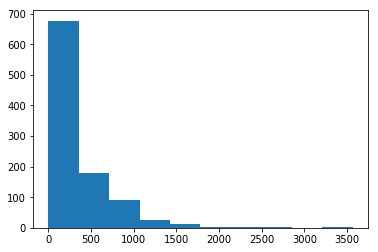

In [64]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

def describe_data(data):
    print 'Mean:', np.mean(data)
    print 'Standard deviation:', np.std(data)
    print 'Minimum:', np.min(data)
    print 'Maximum:', np.max(data)
    plt.hist(data)

total_minutes = total_minutes_by_account.values()
describe_data(total_minutes)

## Debugging Data Analysis Code

In [65]:
#####################################
#                 8                 #
#####################################

## Go through a similar process as before to see if there is a problem.
## Locate at least one surprising piece of data, output it, and take a look at it.

## Lessons Completed in First Week

Mean: 1.63618090452
Standard deviation: 3.00256129983
Minimum: 0
Maximum: 36


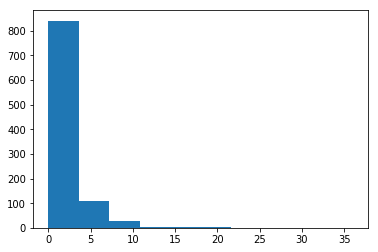

In [66]:
#####################################
#                 9                 #
#####################################

## Adapt the code above to find the mean, standard deviation, minimum, and maximum for
## the number of lessons completed by each student during the first week. Try creating
## one or more functions to re-use the code above.

lessons_completed_by_account = sum_grouped_items(engagement_by_account, 'lessons_completed')

total_lessons = lessons_completed_by_account.values()
describe_data(total_lessons)

## Number of Visits in First Week

Mean: 2.86733668342
Standard deviation: 2.25519800292
Minimum: 0
Maximum: 7


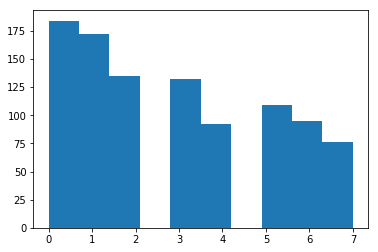

In [67]:
######################################
#                 10                 #
######################################

## Find the mean, standard deviation, minimum, and maximum for the number of
## days each student visits the classroom during the first week.

days_visited_by_account = sum_grouped_items(engagement_by_account, 'has_visited')
describe_data(days_visited_by_account.values())

## Splitting out Passing Students

In [68]:
######################################
#                 11                 #
######################################

## Create two lists of engagement data for paid students in the first week.
## The first list should contain data for students who eventually pass the
## subway project, and the second list should contain data for students
## who do not.

subway_project_lesson_keys = ['746169184', '3176718735']

pass_subway_project = set()

for submission in non_udacity_submissions:
    if submission['lesson_key'] in subway_project_lesson_keys:
        if submission['assigned_rating'] == 'PASSED' or submission['assigned_rating'] == 'DISTINCTION':
            pass_subway_project.add(submission['account_key'])
            
len(pass_subway_project)

651

In [69]:
passing_engagement = []
non_passing_engagement = []

for engagement in paid_engagement_in_first_week:
    if engagement['account_key'] in pass_subway_project:
        passing_engagement.append(engagement)
    else:
        non_passing_engagement.append(engagement)
        
print(len(passing_engagement))
print(len(non_passing_engagement))

4527
2392


## Comparing the Two Student Groups

In [70]:
######################################
#                 12                 #
######################################

## Compute some metrics you're interested in and see how they differ for
## students who pass the subway project vs. students who don't. A good
## starting point would be the metrics we looked at earlier (minutes spent
## in the classroom, lessons completed, and days visited).

passing_engagement_by_account = defaultdict(list)
for engagement in passing_engagement:
    account_key = engagement['account_key']
    passing_engagement_by_account[account_key].append(engagement)
    
non_passing_engagement_by_account = defaultdict(list)
for engagement in non_passing_engagement:
    account_key = engagement['account_key']
    non_passing_engagement_by_account[account_key].append(engagement)

Mean: 394.586046484
Standard deviation: 448.499519327
Minimum: 0.0
Maximum: 3564.7332645


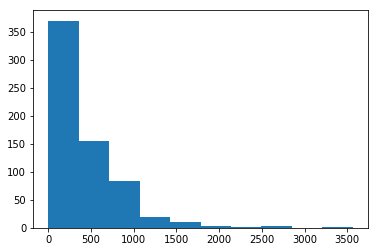

In [71]:
passing_minutes_spent_by_account = sum_grouped_items(passing_engagement_by_account, 'total_minutes_visited')
describe_data(passing_minutes_spent_by_account.values())

Mean: 143.326474267
Standard deviation: 269.538619011
Minimum: 0.0
Maximum: 1768.52274933


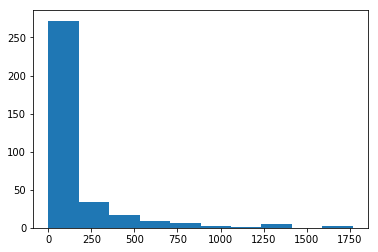

In [72]:
non_passing_minutes_spent_by_account = sum_grouped_items(non_passing_engagement_by_account, 'total_minutes_visited')
describe_data(non_passing_minutes_spent_by_account.values())

## Making Histograms

In [73]:
######################################
#                 13                 #
######################################

## Make histograms of the three metrics we looked at earlier for both
## students who passed the subway project and students who didn't. You
## might also want to make histograms of any other metrics you examined.


## Improving Plots and Sharing Findings

In [ ]:
######################################
#                 14                 #
######################################

## Make a more polished version of at least one of your visualizations
## from earlier. Try importing the seaborn library to make the visualization
## look better, adding axis labels and a title, and changing one or more
## arguments to the hist() function.